# Bayesian Modelling with Bambi

## Libraries

**Note: The cell below is only necessary if using Google Colab**

In [ ]:
# For Google Colab:
!pip install bambi
!pip install mplsoccer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.6 MB/s eta 0:00:00


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import bambi as bmb
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import statsmodels.api as sm
from mplsoccer import Pitch

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


---

## Data Prep

In [2]:
df_full = pd.read_csv("statsbomb_open_shots_extended.csv")

# For Google Colab:
# df_full = pd.DataFrame()
# for chunk in pd.read_csv("statsbomb_open_shots_extended.csv", chunksize=10000, engine="python"):
#   df_full = pd.concat([df_full, chunk], ignore_index=True)

In [3]:
df_full.competition.value_counts()

competition
Spain - La Liga                                      19625
England - Premier League                             10242
Italy - Serie A                                       9427
France - Ligue 1                                      8261
Germany - 1. Bundesliga                               7360
International - FIFA World Cup                        3558
India - Indian Super league                           2877
Europe - UEFA Euro                                    1187
Europe - Champions League                              501
Europe - UEFA Europa League                             84
Spain - Copa del Rey                                    64
Argentina - Liga Profesional                            48
North and Central America - North American League       48
International - FIFA U20 World Cup                      27
Name: count, dtype: int64

Going to just use the premier league (~10,000 shots) to reduce sampling times as it gives a good representation of different players and match-ups (whereas La Liga is mostly Barcelona players and matches from the Messi data).

Also only select variables which could potentially impact goal probability.

In [4]:
predictors = ["distance_to_goal",
              "shot_angle",
              "gk_distance_to_goal",
              "players_in_shot_triangle",
              "opponents_in_radius",
              "shot_body_part",
              "shot_first_time",
              "gk_in_shot_triangle",
              "shot_one_on_one",
              "shot_open_goal",
              "shot_technique",
              "under_pressure",
              "general_position",
              "player",
              "goal",
              "shot_statsbomb_xg"]

df_prem = df_full.query("competition == 'England - Premier League'")[predictors].reset_index(drop=True).copy()

In [5]:
df_prem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10242 entries, 0 to 10241
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   distance_to_goal          10242 non-null  float64
 1   shot_angle                10242 non-null  float64
 2   gk_distance_to_goal       10242 non-null  float64
 3   players_in_shot_triangle  10242 non-null  int64  
 4   opponents_in_radius       10242 non-null  int64  
 5   shot_body_part            10242 non-null  object 
 6   shot_first_time           3207 non-null   object 
 7   gk_in_shot_triangle       10242 non-null  bool   
 8   shot_one_on_one           493 non-null    object 
 9   shot_open_goal            116 non-null    object 
 10  shot_technique            10242 non-null  object 
 11  under_pressure            2315 non-null   object 
 12  general_position          10242 non-null  object 
 13  player                    10242 non-null  object 
 14  goal  

Going to follow a similar procedure as for non-Bayesian modelling w.r.t preparing the features for modelling. However, *bambi* allows for using categorical features as predictors, so we don't need to encode those features and instead just convert them to categorical types.

- Include an interaction between `distance_to_goal` and `shot_angle`.
- Scale all continuous variables to [0,1].
- Convert categorical features to correct type.

Add interaction:

In [6]:
df_prem["dist_angle_interaction"] = df_prem.distance_to_goal * df_prem.shot_angle

Scale continuous variables:

In [308]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(df_prem[["distance_to_goal","shot_angle","dist_angle_interaction","gk_distance_to_goal"]])).rename(
     columns={0:"distance_to_goal", 1:"shot_angle", 2:"dist_angle_interaction", 3:"gk_distance_to_goal"}
)

Convet categorical features:

In [309]:
categoricals = ["players_in_shot_triangle",
                "opponents_in_radius",
                "shot_body_part",
                "shot_first_time",
                "gk_in_shot_triangle",
                "shot_one_on_one",
                "shot_open_goal",
                "shot_technique",
                "under_pressure",
                "general_position",
                "player"]

for col in categoricals:
    df[col] = df_prem[col].replace({True: 1, False: 0, np.nan: 0}).astype("category")

Add goal as the outcome variable:

In [310]:
df["goal"] = df_prem.goal

In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10242 entries, 0 to 10241
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   distance_to_goal          10242 non-null  float64 
 1   shot_angle                10242 non-null  float64 
 2   dist_angle_interaction    10242 non-null  float64 
 3   gk_distance_to_goal       10242 non-null  float64 
 4   players_in_shot_triangle  10242 non-null  category
 5   opponents_in_radius       10242 non-null  category
 6   shot_body_part            10242 non-null  category
 7   shot_first_time           10242 non-null  category
 8   gk_in_shot_triangle       10242 non-null  category
 9   shot_one_on_one           10242 non-null  category
 10  shot_open_goal            10242 non-null  category
 11  shot_technique            10242 non-null  category
 12  under_pressure            10242 non-null  category
 13  general_position          10242 non-null  cate

---

## Justifying Using Bayesian Methods

To show why using Bayesian methods can be used to improve xG models we use Bayes' theorem to adjust xG values based on position and compare the results. To adjust the StatsBomb xG value by general position, we use Bayes' theorem:

$P(goal|position_i) = \frac{P(position_i|goal)*P(goal)}{P(position_i)}$

In [11]:
df_position = df_prem[["general_position","goal","shot_statsbomb_xg"]].copy()

p_goal = df_prem.shot_statsbomb_xg.mean()

p_position = {"ST": df_prem.general_position.value_counts(normalize=True)["ST"],
             "AM": df_prem.general_position.value_counts(normalize=True)["AM"],
             "M": df_prem.general_position.value_counts(normalize=True)["M"],
             "D": df_prem.general_position.value_counts(normalize=True)["D"]}

p_position_goal = {"ST": df_prem[df_prem.goal].general_position.value_counts(normalize=True)["ST"],
                  "AM": df_prem[df_prem.goal].general_position.value_counts(normalize=True)["AM"],
                  "M": df_prem[df_prem.goal].general_position.value_counts(normalize=True)["M"],
                  "D": df_prem[df_prem.goal].general_position.value_counts(normalize=True)["D"]}

df_position["adjusted_xg"] = [(p_position_goal[pos]*p_goal) / p_position[pos] for pos in df_position.general_position]

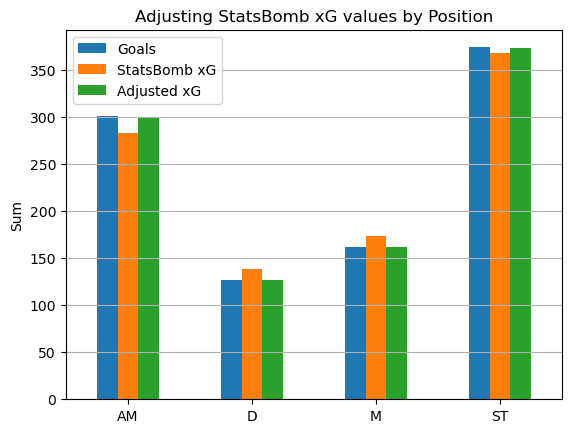

In [12]:
df_position.groupby("general_position").sum().rename(
    columns={"goal":"Goals", "shot_statsbomb_xg":"StatsBomb xG", "adjusted_xg":"Adjusted xG"}
).plot(kind="bar")

plt.title("Adjusting StatsBomb xG values by Position")
plt.ylabel("Sum")
plt.xlabel("")
plt.xticks(rotation=0)
plt.grid(axis="y")

plt.show()

By adjusting xG values by position, we see that the sum of the adjusted values is closer to the actual total number of goals scored for each position. This shows the potential benefit of using Bayesian methods to predict xG values.

---

## Bayesian Modelling

The model we will be building is of the form:

$logit(p) = log(\frac{p}{1-p}) = \beta_0 + \beta_1X_1 + ... + \beta_kX_k$

where $p = P(goal)$ and $\beta_0, \beta_1, ..., \beta_k$ are unknown parameters to estimate.

The likelihood is the product of $n$ Bernoulli trials: $\prod_{i=1}^{n}p_i^{y_i}(1 - p_i)^{1-y_i}$ where $p_i = P(goal)$.

We now put this information into some Bambi models, starting with only considering the general position (strikers, attacking midfielders, other midfielders, defenders) of the player taking the shot.

We will first fit a model with just distance to goal and shot angle as predictors, and then add general position to create a multi-level model. We choose `distance_to_goal` and `shot_angle` as they are often considered the most important predictors.

---

### Basic Positional Model

$logit(p_i) = \beta_0 + \beta_1*$ distance_to_goal $+ \beta_2*$ shot_angle $+ \beta_3*$ distance_angle_interaction

A normal distribution is used as a prior for the intercept, with `mu=0` and `simga=5` to allow for plenty of movement around 0. As `distance_to_goal` increases, it is expected that the average goal probability decreases. Therefore, a skewed normal distribution is used with a skew towards negative values, but still with `sigma=5` to allow for uncertainty. Conversely, as `shot_angle` increases it is expected that average goal probability increases as this correspond to being closer and more central to the goal. Therefore, another skewed normal distribution is used but with a positive skew value.

In [13]:
pos_baseline = bmb.Model("goal ~ distance_to_goal + shot_angle + dist_angle_interaction", df, family="bernoulli")

pos_baseline_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "distance_to_goal": bmb.Prior("SkewNormal", mu=-1, sigma=5, alpha=-1),
    "shot_angle": bmb.Prior("SkewNormal", mu=1, sigma=5, alpha=1),
    "dist_angle_interaction": bmb.Prior("Normal", mu=0, sigma=5)
}
pos_baseline.set_priors(pos_baseline_priors)

pos_baseline

       Formula: goal ~ distance_to_goal + shot_angle + dist_angle_interaction
        Family: bernoulli
          Link: p = logit
  Observations: 10242
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            distance_to_goal ~ SkewNormal(mu: -1.0, sigma: 5.0, alpha: -1.0)
            shot_angle ~ SkewNormal(mu: 1.0, sigma: 5.0, alpha: 1.0)
            dist_angle_interaction ~ Normal(mu: 0.0, sigma: 5.0)

In [14]:
pos_baseline_fitted = pos_baseline.fit(draws=100, tune=100, chains=4, target_accept=0.95)

Modeling the probability that goal==1
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, distance_to_goal, shot_angle, dist_angle_interaction]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 64 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [15]:
pos_baseline_preds = az.summary(pos_baseline.predict(pos_baseline_fitted, inplace=False), kind="stats")

---

### Basic Hierarchical Positional Model

$logit(p_{i}) = \beta_0 + \beta_1*$ distance_to_goal $+ \beta_2*$ shot_angle $+ \beta_3*$distance_angle_interaction $+ \beta_j*$ general_position 

where $j$ is the index of the position of player $i$ (ST, AM, M, or D).

The additional priors here are also skewed normal, with the skew being positive for strikers and attacking midfielders, negative for defenders, and between the two for other midfielders.

To make sure the priors are properly set, check the order of the general_position category:

In [16]:
df.general_position.cat.categories

Index(['AM', 'D', 'M', 'ST'], dtype='object')

Therefore, priors will have skews (alpha): `[1,-2,0,2]`.

In [17]:
pos_model = bmb.Model("goal ~ distance_to_goal + shot_angle + dist_angle_interaction + (1|general_position)", df, family="bernoulli")

pos_priors = pos_baseline_priors | {
    "1|general_position": bmb.Prior("SkewNormal", mu=[0,0,0,0], sigma=bmb.Prior("HalfNormal", sigma=5), alpha=[1,-2,0,2])
}
pos_model.set_priors(pos_priors)

pos_model

       Formula: goal ~ distance_to_goal + shot_angle + dist_angle_interaction + (1|general_position)
        Family: bernoulli
          Link: p = logit
  Observations: 10242
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            distance_to_goal ~ SkewNormal(mu: -1.0, sigma: 5.0, alpha: -1.0)
            shot_angle ~ SkewNormal(mu: 1.0, sigma: 5.0, alpha: 1.0)
            dist_angle_interaction ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|general_position ~ SkewNormal(mu: [0 0 0 0], sigma: HalfNormal(sigma: 5.0), alpha: [ 1 -2  0
                2])

In [18]:
pos_fitted = pos_model.fit(draws=100, tune=100, chains=4, target_accept=0.95)

Modeling the probability that goal==1
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, distance_to_goal, shot_angle, dist_angle_interaction, 1|general_position_sigma, 1|general_position_offset]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [19]:
pos_preds = az.summary(pos_model.predict(pos_fitted, inplace=False), kind="stats")

In [20]:
pos_summary = pd.DataFrame()
pos_summary["pos"] = df.general_position
pos_summary["baseline"] = pos_baseline_preds.iloc[az.summary(pos_baseline_fitted).shape[0]:,0].values
pos_summary["adjusted"] = pos_preds.iloc[az.summary(pos_fitted).shape[0]:,0].values
pos_summary["diff"] = pos_summary.adjusted - pos_summary.baseline

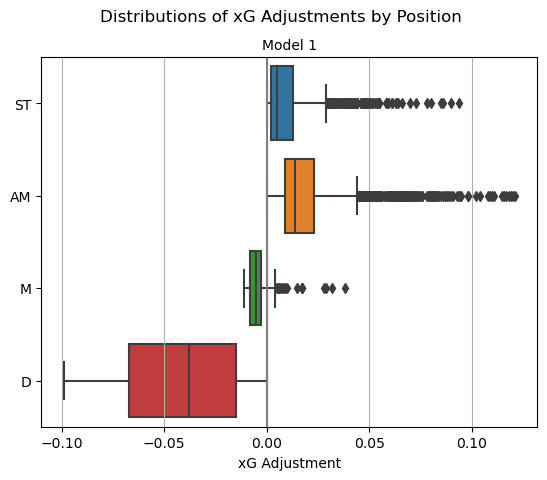

In [305]:
sns.boxplot(pos_summary, x="diff", y="pos", order=["ST","AM","M","D"])
plt.axvline(x=0, color="grey")

plt.suptitle("Distributions of xG Adjustments by Position")
plt.title("Model 1", fontsize=10)
plt.xlabel("xG Adjustment")
plt.ylabel("")
plt.grid(axis="x")

plt.show()

We see that strikers and attacking midfielders have a slightly positive xG adjustment on average, while midfielders a slightly negative adjustment on average. Defenders have a relatively large negative xG adjustment of more than 0.04 on average.

Let's look at where each position tends to shoot from:

In [214]:
position_shots = pd.DataFrame(df.general_position)

position_shots["goal"] = df.goal

x = []
y = []

for location in df_full.iloc[position_shots.index].location:
    x.append(eval(location)[0])
    y.append(eval(location)[1])

position_shots["x"] = x
position_shots["y"] = y

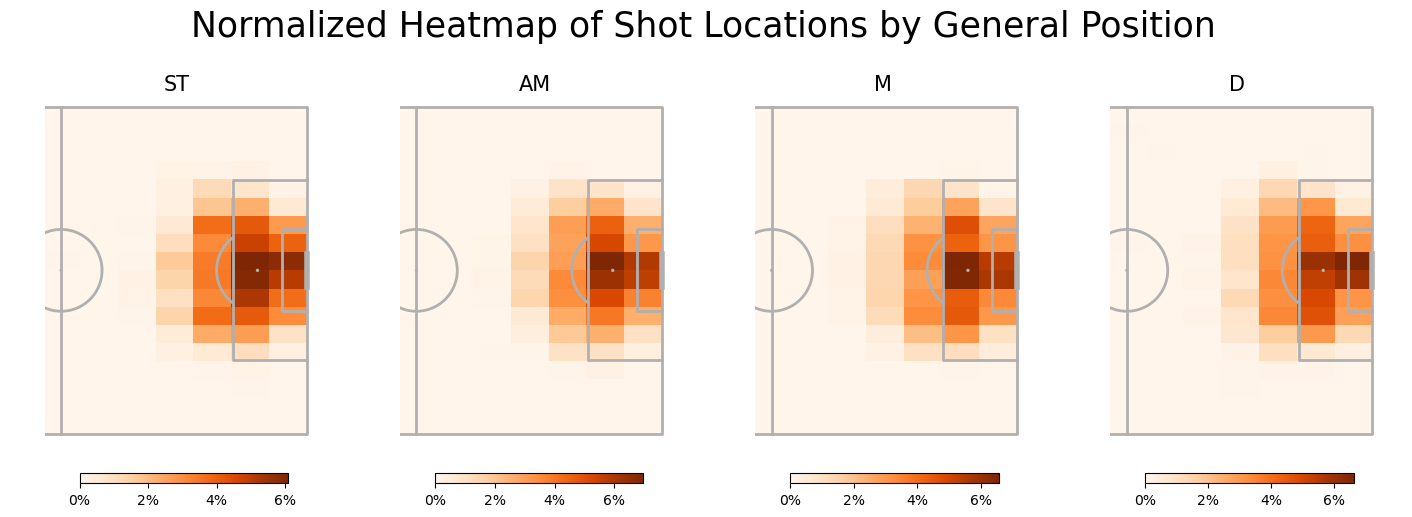

In [303]:
pitch = Pitch(half=True, line_zorder=2)

fig,axs = pitch.grid(ncols=4, nrows=1, axis=False, title_height=0.05, endnote_height=0, grid_height=0.5)

for position, a in zip(["ST","AM","M","D"], axs["pitch"].flat[:len(position_shots.general_position.unique())]):
    position_i_shots = position_shots[position_shots.general_position == position]

    bin_statistic = pitch.bin_statistic(position_i_shots.x, position_i_shots.y, statistic="count", normalize=True, bins=[13,18])
    pcm = pitch.heatmap(bin_statistic, ax=a, cmap="Oranges")

    plt.colorbar(pcm, ax=a, shrink=0.6, location="bottom", pad=0.05, format=ticker.PercentFormatter(xmax=1, decimals=0))

    a.text(85, -4, position, fontsize=15)

axs["title"].text(0.13, 1, "Normalized Heatmap of Shot Locations by General Position", fontsize=25)

plt.show()

To analyse these effects more, we look at the predictors inidividually and see how predictions vary for different values. First, we see how `distance_to_goal` is distributed between the different positions.

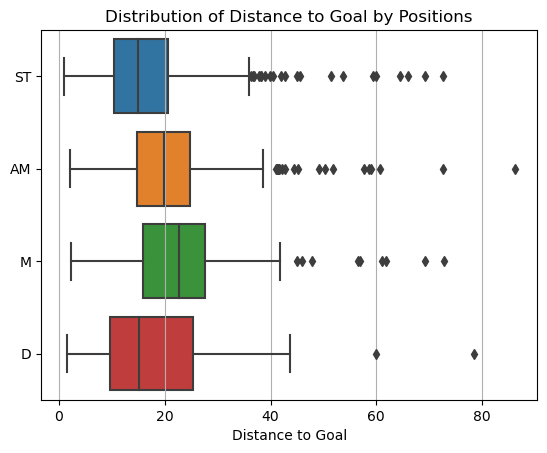

In [22]:
sns.boxplot(
    pd.concat([pd.DataFrame(scaler.inverse_transform(df[["distance_to_goal","shot_angle","dist_angle_interaction","gk_distance_to_goal"]])).rename(
    columns={0:"distance_to_goal", 1:"shot_angle", 2:"dist_angle_interaction", 3:"gk_distance_to_goal"}
    ), df.general_position], axis="columns"),
            x="distance_to_goal", y="general_position", order=["ST","AM","M","D"])

plt.title("Distribution of Distance to Goal by Positions")
plt.ylabel("")
plt.xlabel("Distance to Goal")
plt.grid(axis="x")

plt.show()

No noticable difference in the distribution of `distance_to_goal` by position.

Next, we see how the predictions vary by position for different values of `distance_to_goal`.

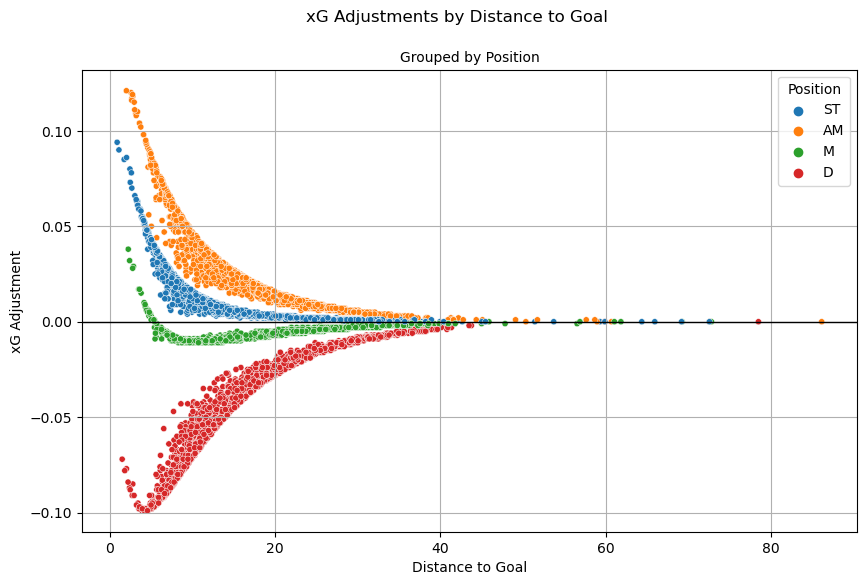

In [23]:
plt.subplots(figsize=(10,6))
sns.scatterplot(x=[x[0] for x in scaler.inverse_transform(df[["distance_to_goal","shot_angle","dist_angle_interaction","gk_distance_to_goal"]])],
                y=pos_summary["diff"],
                hue=pos_summary.pos.rename("Position"), hue_order=["ST","AM","M","D"],
                s=20)
plt.axhline(y=0, color="black", linewidth=1)

plt.suptitle("xG Adjustments by Distance to Goal")
plt.title("Grouped by Position", fontsize=10)
plt.xlabel("Distance to Goal")
plt.ylabel("xG Adjustment")
plt.grid()

plt.show()

Interestingly, the difference in predictions between the baseline model and the position-adjusted multi-level model are most exaggerated for shots taken closer to the goal. The plot suggests that if a shot is taken close to the goal the most likely position to score on average is attacking midfielders, followed by strikers, then other midfielders, before there is a large drop in defenders. It is interesting that attacking midfielders tend to be more clinical than strikers across the board. As distance increases, predictions converge to being the same as the baseline model, implying there is no impact of player position on goal probability. This will also be capturing the effect that after a certain point the probability of scoring becomes very close to 0 regardless.

Next, we look at `shot_angle`.

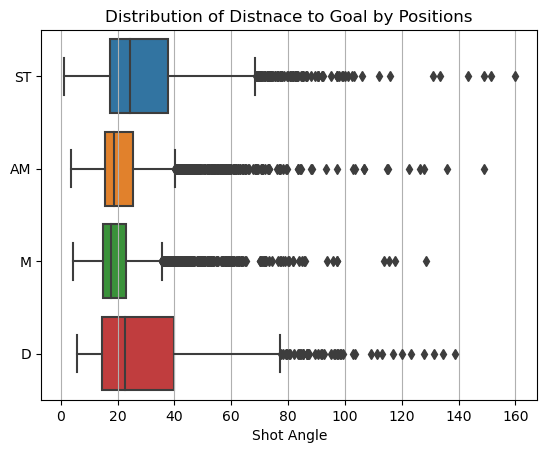

In [24]:
sns.boxplot(
    pd.concat([pd.DataFrame(scaler.inverse_transform(df[["distance_to_goal","shot_angle","dist_angle_interaction","gk_distance_to_goal"]])).rename(
    columns={0:"distance_to_goal", 1:"shot_angle", 2:"dist_angle_interaction", 3:"gk_distance_to_goal"}
    ), df.general_position], axis="columns"),
            x="shot_angle", y="general_position", order=["ST","AM","M","D"])

plt.title("Distribution of Distnace to Goal by Positions")
plt.ylabel("")
plt.xlabel("Shot Angle")
plt.grid(axis="x")

plt.show()

Again, not a massive difference in the distributions of shot_angle, with the exception of AMs and Ms having smaller IQR, likely due to wingers and wide midfielders taking shots from either side of the goal often.

Then, look at how predictions vary for `shot_angle` based on player position.

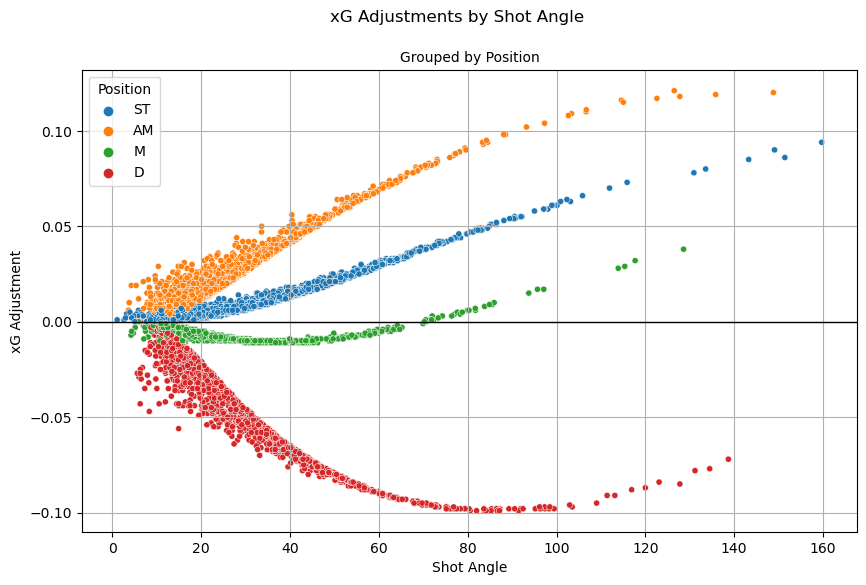

In [25]:
plt.subplots(figsize=(10,6))
sns.scatterplot(x=[x[1] for x in scaler.inverse_transform(df[["distance_to_goal","shot_angle","dist_angle_interaction","gk_distance_to_goal"]])],
                y=pos_summary["diff"],
                hue=pos_summary.pos.rename("Position"), hue_order=["ST","AM","M","D"],
                s=20)
plt.axhline(y=0, color="black", linewidth=1)

plt.suptitle("xG Adjustments by Shot Angle")
plt.title("Grouped by Position", fontsize=10)
plt.xlabel("Shot Angle")
plt.ylabel("xG Adjustment")
plt.grid()

plt.show()

Since `shot_angle` and `distance_to_goal` are inherently linked, we see a similar effect here whereby as `shot_angle` increases (generally meaning `distance_to_goal` decreases) the difference between the positions becomes more pronounced, while for low `shot_angles` (and therefore generally high `distance_to_goal`) the differences are close to 0 for each position.

We can also compare these probability adjustments to what we would expect theoretically, using Bayes' Theorem:

$P(goal | position_i) = \frac{P(position_i | goal) * P(goal)}{P(position_i)}$

We use the average goal probability here because we cannot reliably estimate $P(position_i | goal_i)$ for each chance $i$.

In [26]:
p_goal = df.goal.mean()

p_pos = {"ST": df[df.general_position == "ST"].shape[0] / df.shape[0],
         "AM": df[df.general_position == "AM"].shape[0] / df.shape[0],
         "M": df[df.general_position == "M"].shape[0] / df.shape[0],
         "D": df[df.general_position == "D"].shape[0] / df.shape[0]}

p_pos_goal = {"ST": df[(df.general_position == "ST") & (df.goal)].shape[0] / df[df.goal].shape[0],
                     "AM": df[(df.general_position == "AM") & (df.goal)].shape[0] / df[df.goal].shape[0],
                     "M": df[(df.general_position == "M") & (df.goal)].shape[0] / df[df.goal].shape[0],
                     "D": df[(df.general_position == "D") & (df.goal)].shape[0] / df[df.goal].shape[0]}

pos_summary["theoretical"] = [((p_pos_goal[pos_summary.pos[row]] * p_goal) / p_pos[pos_summary.pos[row]]) for row in pos_summary.index]
pos_summary["theoretical_diff"] = pos_summary.theoretical - pos_summary.baseline

In [27]:
pos_summary.groupby("pos")[["diff","theoretical_diff"]].mean().round(3)

,diff,theoretical_diff
pos,,
AM,0.019,0.020
D,-0.043,-0.044
M,-0.005,-0.005
ST,0.010,0.010


The difference between the theoretical mean by position and baseline xG for each position is close to the average for each position, showing that the Bayesian model is performing well against theoretical values.

---

### Extended Hierarchical Positional Model

Now we can add more predictors to the model to account for the other characteristics of a shot that determine goal probability.

$logit(p_{ij}) = \beta_0 + \sum_1^n{\beta_nX_n} + \beta_{n+1,j}*$ general_position 

where $j = (ATT,MID,DEF)$ and $X_n$ is predictor $n$.

We still train two models, one without the group level positional effects, and one with those effects, to see the impact these effects have on predictions.

First, we train the model without the group-level effects.

In [29]:
full_model_predictors = [
    "distance_to_goal",
    "shot_angle",
    "dist_angle_interaction",
    "gk_distance_to_goal",
    "players_in_shot_triangle",
    "opponents_in_radius",
    "shot_body_part",
    "shot_first_time",
    "gk_in_shot_triangle",
    "shot_one_on_one",
    "shot_open_goal",
    "shot_technique",
    "under_pressure"
]

full_baseline_formula = f"goal ~ 1 {' '.join(['+ ' + str(predictor) for predictor in full_model_predictors])}"

full_baseline = bmb.Model(full_baseline_formula, df, family="bernoulli")

full_baseline_priors = pos_baseline_priors | {
    "gk_distance_to_goal": bmb.Prior("Normal", mu=0, sigma=5),
    "players_in_shot_triangle": bmb.Prior("SkewNormal", mu=0, sigma=5, alpha=[5,4,3,2,1,0,-1,-2,-3,-4,-5]),
    "opponents_in_radius": bmb.Prior("SkewNormal", mu=0, sigma=5, alpha=[1,0,-1,-2]),
    "shot_body_part": bmb.Prior("Normal", mu=0, sigma=5),
    "shot_first_time": bmb.Prior("Normal", mu=0, sigma=5),
    "gk_in_shot_triangle": bmb.Prior("SkewNormal", mu=0, sigma=5, alpha=-2),
    "shot_one_on_one": bmb.Prior("SkewNormal", mu=0, sigma=5, alpha=2),
    "shot_open_goal": bmb.Prior("SkewNormal", mu=0, sigma=5, alpha=4),
    "shot_technique": bmb.Prior("Normal", mu=0, sigma=5),
    "under_pressure": bmb.Prior("SkewNormal", mu=0, sigma=5, alpha=-2)
}
full_baseline.set_priors(full_baseline_priors)

full_baseline

       Formula: goal ~ 1 + distance_to_goal + shot_angle + dist_angle_interaction + gk_distance_to_goal + players_in_shot_triangle + opponents_in_radius + shot_body_part + shot_first_time + gk_in_shot_triangle + shot_one_on_one + shot_open_goal + shot_technique + under_pressure
        Family: bernoulli
          Link: p = logit
  Observations: 10242
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            distance_to_goal ~ SkewNormal(mu: -1.0, sigma: 5.0, alpha: -1.0)
            shot_angle ~ SkewNormal(mu: 1.0, sigma: 5.0, alpha: 1.0)
            dist_angle_interaction ~ Normal(mu: 0.0, sigma: 5.0)
            gk_distance_to_goal ~ Normal(mu: 0.0, sigma: 5.0)
            players_in_shot_triangle ~ SkewNormal(mu: 0.0, sigma: 5.0, alpha: [ 5  4  3  2  1  0 -1 -2 -3 -4
                -5])
            opponents_in_radius ~ SkewNormal(mu: 0.0, sigma: 5.0, alpha: [ 1  0 -1 -2])
            shot_body_part ~ Normal(mu: 0.0

In [30]:
full_baseline_fitted = full_baseline.fit(draws=100, tune=100, chains=4, target_accept=0.95)

Modeling the probability that goal==1
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, distance_to_goal, shot_angle, dist_angle_interaction, gk_distance_to_goal, players_in_shot_triangle, opponents_in_radius, shot_body_part, shot_first_time, gk_in_shot_triangle, shot_one_on_one, shot_open_goal, shot_technique, under_pressure]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 809 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [31]:
full_baseline_preds = az.summary(full_baseline.predict(full_baseline_fitted, inplace=False), kind="stats")

Now, we train the model with the same predictors but with positional group effects.

In [32]:
full_model_formula = f"goal ~ 1 {' '.join(['+ ' + str(predictor) for predictor in full_model_predictors])} + (1|general_position)"

full_model = bmb.Model(full_model_formula, df, family="bernoulli")

full_model_priors = full_baseline_priors | {"1|general_position": bmb.Prior("SkewNormal", mu=[0,0,0,0], sigma=bmb.Prior("HalfNormal", sigma=5), alpha=[1,-2,0,2])}
full_model.set_priors(full_model_priors)

full_model

       Formula: goal ~ 1 + distance_to_goal + shot_angle + dist_angle_interaction + gk_distance_to_goal + players_in_shot_triangle + opponents_in_radius + shot_body_part + shot_first_time + gk_in_shot_triangle + shot_one_on_one + shot_open_goal + shot_technique + under_pressure + (1|general_position)
        Family: bernoulli
          Link: p = logit
  Observations: 10242
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            distance_to_goal ~ SkewNormal(mu: -1.0, sigma: 5.0, alpha: -1.0)
            shot_angle ~ SkewNormal(mu: 1.0, sigma: 5.0, alpha: 1.0)
            dist_angle_interaction ~ Normal(mu: 0.0, sigma: 5.0)
            gk_distance_to_goal ~ Normal(mu: 0.0, sigma: 5.0)
            players_in_shot_triangle ~ SkewNormal(mu: 0.0, sigma: 5.0, alpha: [ 5  4  3  2  1  0 -1 -2 -3 -4
                -5])
            opponents_in_radius ~ SkewNormal(mu: 0.0, sigma: 5.0, alpha: [ 1  0 -1 -2])
            shot_bod

In [33]:
full_fitted = full_model.fit(draws=100, tune=100, chains=4, target_accept=0.95)

Modeling the probability that goal==1
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, distance_to_goal, shot_angle, dist_angle_interaction, gk_distance_to_goal, players_in_shot_triangle, opponents_in_radius, shot_body_part, shot_first_time, gk_in_shot_triangle, shot_one_on_one, shot_open_goal, shot_technique, under_pressure, 1|general_position_sigma, 1|general_position_offset]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 845 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [34]:
full_preds = az.summary(full_model.predict(full_fitted, inplace=False), kind="stats")

In [35]:
full_pos_summary = pd.DataFrame()
full_pos_summary["pos"] = df.general_position
full_pos_summary["baseline"] = full_baseline_preds.iloc[az.summary(full_baseline_fitted).shape[0]:,0].values
full_pos_summary["adjusted"] = full_preds.iloc[az.summary(full_fitted).shape[0]:,0].values
full_pos_summary["diff"] = full_pos_summary.adjusted - full_pos_summary.baseline

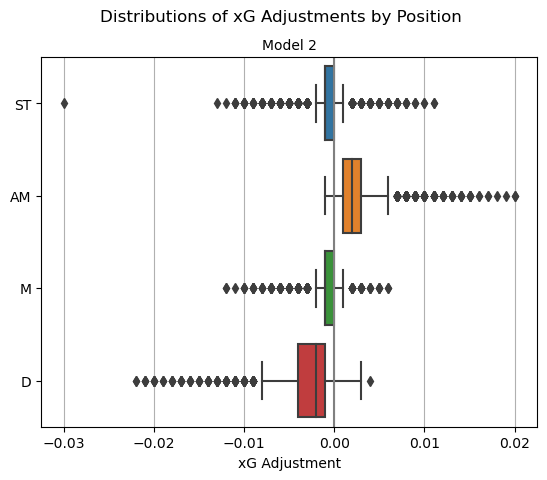

In [306]:
sns.boxplot(full_pos_summary, x="diff", y="pos", order=["ST","AM","M","D"])
plt.axvline(x=0, color="grey")

plt.suptitle("Distributions of xG Adjustments by Position")
plt.title("Model 2", fontsize=10)
plt.xlabel("xG Adjustment")
plt.ylabel("")
plt.grid(axis="x")

plt.show()

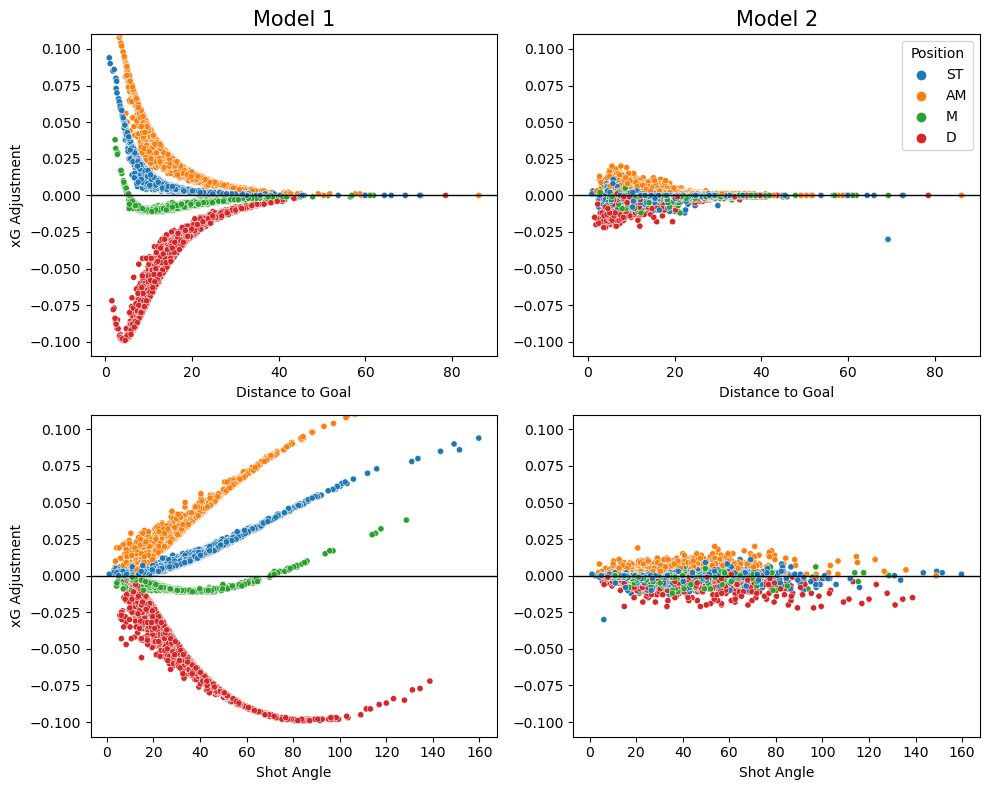

In [312]:
f,a = plt.subplots(2,2, figsize=(10,8))

sns.scatterplot(x=[x[0] for x in scaler.inverse_transform(df[["distance_to_goal","shot_angle","dist_angle_interaction","gk_distance_to_goal"]])],
                y=pos_summary["diff"],
                hue=pos_summary.pos, hue_order=["ST","AM","M","D"],
                s=20, ax=a[0,0], legend=False)
a[0,0].axhline(y=0, color="black", linewidth=1)
a[0,0].set_ylim(-0.11,0.11)
a[0,0].set_title("Model 1", fontsize=15)
a[0,0].set_xlabel("Distance to Goal")
a[0,0].set_ylabel("xG Adjustment")

sns.scatterplot(x=[x[0] for x in scaler.inverse_transform(df[["distance_to_goal","shot_angle","dist_angle_interaction","gk_distance_to_goal"]])],
                y=full_pos_summary["diff"],
                hue=full_pos_summary.pos.rename("Position"), hue_order=["ST","AM","M","D"],
                s=20, ax=a[0,1])
a[0,1].axhline(y=0, color="black", linewidth=1)
a[0,1].set_ylim(-0.11,0.11)
a[0,1].set_title("Model 2", fontsize=15)
a[0,1].set_xlabel("Distance to Goal")
a[0,1].set_ylabel("")

sns.scatterplot(x=[x[1] for x in scaler.inverse_transform(df[["distance_to_goal","shot_angle","dist_angle_interaction","gk_distance_to_goal"]])],
                y=pos_summary["diff"],
                hue=pos_summary.pos, hue_order=["ST","AM","M","D"],
                s=20, ax=a[1,0], legend=False)
a[1,0].axhline(y=0, color="black", linewidth=1)
a[1,0].set_ylim(-0.11,0.11)
a[1,0].set_xlabel("Shot Angle")
a[1,0].set_ylabel("xG Adjustment")

sns.scatterplot(x=[x[1] for x in scaler.inverse_transform(df[["distance_to_goal","shot_angle","dist_angle_interaction","gk_distance_to_goal"]])],
                y=full_pos_summary["diff"],
                hue=full_pos_summary.pos, hue_order=["ST","AM","M","D"],
                s=20, ax=a[1,1], legend=False)
a[1,1].axhline(y=0, color="black", linewidth=1)
a[1,1].set_ylim(-0.11,0.11)
a[1,1].set_xlabel("Shot Angle")
a[1,1].set_ylabel("")

plt.tight_layout()
plt.show()

After accounting for additional characteristics about shots that influence goal probability, the effect of the position of the shooter has very little effect compared to the basic model (note the axis scale in the bar plot).

This could be because each group contains a wide range of players of different abilities, meaning it may make more sense to look at individual players.

To do this, we will group the data by players for certain players who have taken a lot of shots and we expect to see an xG adjustment for, and simply group everyone else as "other".

---

### Extended Hierarchical Player Model

$logit(p_{ij}) = \beta_0 + \sum_1^n{\beta_nX_n} + \beta_{n+1,j}*$ player 

where $j$ refers to player $j$ and $X_n$ is predictor $n$.

In [38]:
player_stats = pd.DataFrame(index=df.player.unique())
player_stats["shots"] = [df[df.player == player].shape[0] for player in player_stats.index]
player_stats["goals"] = [df[(df.player == player) & (df.goal == True)].shape[0] for player in player_stats.index]
player_stats["conversion_rate"] = round(player_stats.goals / player_stats.shots, 3)

In [39]:
player_stats[player_stats.shots > 50].sort_values("conversion_rate", ascending=False).head(10)

,shots,goals,conversion_rate
Robert Pirès,56,14,0.250
Anthony Martial,57,11,0.193
Sergio Leonel Agüero del Castillo,112,20,0.179
Jamie Vardy,111,19,0.171
Riyad Mahrez,76,13,0.171
André Ayew Pelé,68,11,0.162
Shane Long,63,10,0.159
Diego da Silva Costa,69,11,0.159
Jermain Defoe,89,14,0.157
Roberto Firmino Barbosa de Oliveira,64,10,0.156


In [40]:
player_stats[player_stats.shots > 50].sort_values("conversion_rate").head(10)

,shots,goals,conversion_rate
Jonjo Shelvey,51,0,0.000
Yohan Cabaye,56,2,0.036
Jason Puncheon,51,2,0.039
Christian Dannemann Eriksen,75,4,0.053
Matt Ritchie,76,4,0.053
Wilfried Guemiand Bony,60,4,0.067
Ross Barkley,82,6,0.073
Aaron Ramsey,67,5,0.075
Philippe Coutinho Correia,105,8,0.076
Juan Manuel Mata García,51,4,0.078


Based on the player stats in the table above, we will use:

- Aguero
- Vardy
- Pires
- Shelvey
- Coutinho
- Barkley

The rest of the players will be groups into "other".

We expect the top 3 to have positive xG adjustments, and the bottom 3 to have negative xG adjustments based on their conversion rates.

In [41]:
df["aguero"] = df.player == "Sergio Leonel Agüero del Castillo"
df["vardy"] = df.player == "Jamie Vardy"
df["pires"] = df.player == "Robert Pirès"
df["shelvey"] = df.player == "Jonjo Shelvey"
df["coutinho"] = df.player == "Philippe Coutinho Correia"
df["barkley"] = df.player == "Ross Barkley"

In [42]:
player_formula = f"goal ~ 1 {' '.join(['+ ' + str(predictor) for predictor in full_model_predictors])} + (1|aguero) + (1|vardy) + (1|pires) + (1|shelvey) + (1|coutinho) + (1|barkley)"

player_model = bmb.Model(player_formula, df, family="bernoulli")

player_model_priors = full_baseline_priors | {
    "1|aguero": bmb.Prior("SkewNormal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5), alpha=2),
    "1|vardy": bmb.Prior("SkewNormal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5), alpha=2),
    "1|pires": bmb.Prior("SkewNormal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5), alpha=2),
    "1|shelvey": bmb.Prior("SkewNormal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5), alpha=0),
    "1|coutinho": bmb.Prior("SkewNormal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5), alpha=2),
    "1|barkley": bmb.Prior("SkewNormal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5), alpha=0)
}
player_model.set_priors(player_model_priors)

player_model

       Formula: goal ~ 1 + distance_to_goal + shot_angle + dist_angle_interaction + gk_distance_to_goal + players_in_shot_triangle + opponents_in_radius + shot_body_part + shot_first_time + gk_in_shot_triangle + shot_one_on_one + shot_open_goal + shot_technique + under_pressure + (1|aguero) + (1|vardy) + (1|pires) + (1|shelvey) + (1|coutinho) + (1|barkley)
        Family: bernoulli
          Link: p = logit
  Observations: 10242
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            distance_to_goal ~ SkewNormal(mu: -1.0, sigma: 5.0, alpha: -1.0)
            shot_angle ~ SkewNormal(mu: 1.0, sigma: 5.0, alpha: 1.0)
            dist_angle_interaction ~ Normal(mu: 0.0, sigma: 5.0)
            gk_distance_to_goal ~ Normal(mu: 0.0, sigma: 5.0)
            players_in_shot_triangle ~ SkewNormal(mu: 0.0, sigma: 5.0, alpha: [ 5  4  3  2  1  0 -1 -2 -3 -4
                -5])
            opponents_in_radius ~ SkewNormal(mu: 0.

In [43]:
player_fitted = player_model.fit(draws=100, tune=100, chains=4, target_accept=0.95)

Modeling the probability that goal==1
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, distance_to_goal, shot_angle, dist_angle_interaction, gk_distance_to_goal, players_in_shot_triangle, opponents_in_radius, shot_body_part, shot_first_time, gk_in_shot_triangle, shot_one_on_one, shot_open_goal, shot_technique, under_pressure, 1|aguero_sigma, 1|aguero_offset, 1|vardy_sigma, 1|vardy_offset, 1|pires_sigma, 1|pires_offset, 1|shelvey_sigma, 1|shelvey_offset, 1|coutinho_sigma, 1|coutinho_offset, 1|barkley_sigma, 1|barkley_offset]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 2307 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [44]:
player_preds = az.summary(player_model.predict(player_fitted, inplace=False), kind="stats")

In [45]:
def get_player(row_index):
    if df.aguero[row_index]:
        return "Agüero"
    elif df.vardy[row_index]:
        return "Vardy"
    elif df.pires[row_index]:
        return "Pirès"
    elif df.shelvey[row_index]:
        return "Shelvey"
    elif df.coutinho[row_index]:
        return "Coutinho"
    elif df.barkley[row_index]:
        return "Barkley"
    else:
        return "Other"

In [46]:
player_summary = pd.DataFrame()
player_summary["player"] = [get_player(row) for row in df.index]
player_summary["goal"] = df.goal.reset_index(drop=True)
player_summary["baseline"] = full_baseline_preds.iloc[az.summary(full_baseline_fitted).shape[0]:,0].values
player_summary["adjusted"] = player_preds.iloc[az.summary(player_fitted).shape[0]:,0].values
player_summary["diff"] = player_summary.adjusted - player_summary.baseline

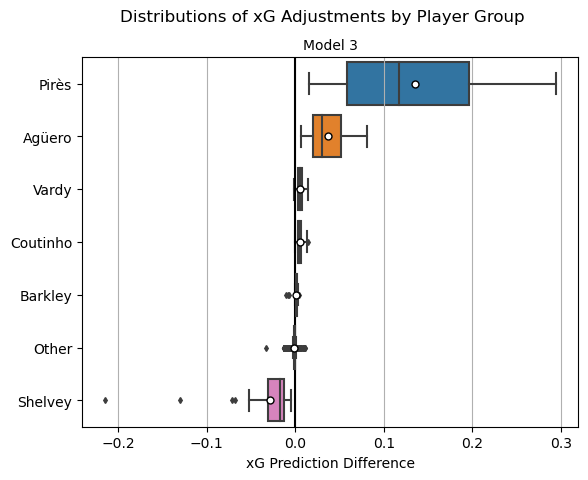

In [315]:
sns.boxplot(data=player_summary, x="diff", y="player", fliersize=3, order=player_summary.groupby("player")["diff"].median().sort_values(ascending=False).index,
            showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":5})
plt.axvline(x=0, color="black")

plt.suptitle("Distributions of xG Adjustments by Player Group")
plt.title("Model 3", fontsize=10)
plt.xlabel("xG Prediction Difference")
plt.ylabel("")

plt.grid(axis="x")

plt.show()

We can see the distributions of xG adjustments for each of the chosen players above, as well as all other players combined.

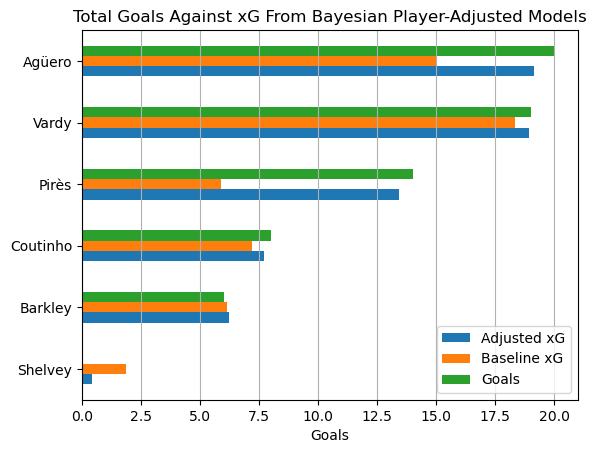

In [161]:
player_summary.groupby("player").sum()[["adjusted","baseline","goal"]].sort_values("goal").drop("Other").rename(
    columns={"goal":"Goals","baseline":"Baseline xG","adjusted":"Adjusted xG"}
).plot(kind="barh")

plt.title("Total Goals Against xG From Bayesian Player-Adjusted Models")
plt.ylabel("")
plt.xlabel("Goals")

plt.grid(axis="x")

plt.show()

The multi-level model more accurately predicts total goals than the baseline models for the chosen players.

Can also compare these to theoretical probabilities using Bayes' Theorem:

$P(goal | player_j) = \frac{P(player_j | goal) * P(goal)}{P(player_j)}$

In [51]:
p_goal = df.goal.mean()

p_player = {"Agüero": df.aguero.sum() / df.shape[0],
            "Vardy": df.vardy.sum() / df.shape[0],
            "Pirès": df.pires.sum() / df.shape[0],
            "Coutinho": df.coutinho.sum() / df.shape[0],
            "Barkley": df.barkley.sum() / df.shape[0],
            "Shelvey": df.shelvey.sum() / df.shape[0],
            "Other": df[~df.aguero & ~df.vardy & ~df.pires & ~df.coutinho & ~df.barkley & ~df.shelvey].shape[0] / df.shape[0]}

p_player_goal = {"Agüero": df[(df.goal == 1) & df.aguero].shape[0] / df[(df.goal == 1)].shape[0],
                   "Vardy": df[(df.goal == 1) & df.vardy].shape[0] / df[(df.goal == 1)].shape[0],
                   "Pirès": df[(df.goal == 1) & df.pires].shape[0] / df[(df.goal == 1)].shape[0],
                   "Coutinho": df[(df.goal == 1) & df.coutinho].shape[0] / df[(df.goal == 1)].shape[0],
                   "Barkley": df[(df.goal == 1) & df.barkley].shape[0] / df[(df.goal == 1)].shape[0],
                   "Shelvey": df[(df.goal == 1) & df.shelvey].shape[0] / df[(df.goal == 1)].shape[0],
                   "Other": df[~df.aguero & ~df.vardy & ~df.pires & ~df.coutinho & ~df.barkley & ~df.shelvey & (df.goal == 1)].shape[0] / df[(df.goal == 1)].shape[0]}

player_summary["theoretical"] = [((p_player_goal[player_summary.player[row]] * p_goal) / p_player[player_summary.player[row]]) for row in player_summary.index]
player_summary["theoretical_diff"] = player_summary.theoretical - player_summary.baseline

In [66]:
player_summary.groupby("player")[["diff","theoretical_diff"]].mean().round(3)

,diff,theoretical_diff
player,,
Agüero,0.037,0.044
Barkley,0.001,-0.002
Coutinho,0.005,0.008
Other,-0.001,-0.001
Pirès,0.135,0.145
Shelvey,-0.028,-0.036
Vardy,0.006,0.006


Again, all the mean theoretical adjustments are relatively close to the average value for each player, suggesting the model performs well against theoretical expectations.

Looking at shot locations and outcomes on a pitch may shine some light on the results here.

In [157]:
player_shots = pd.DataFrame(pd.Series([get_player(row) for row in df.index]).rename("player").loc[
                            lambda x: x.isin(["Pirès","Agüero","Vardy","Coutinho","Barkley","Shelvey"])
                            ])

player_shots["goal"] = df.goal[player_shots.index]

player_x = []
player_y = []

for location in df_full.iloc[player_shots.index].location:
    player_x.append(eval(location)[0])
    player_y.append(eval(location)[1])

player_shots["x"] = player_x
player_shots["y"] = player_y

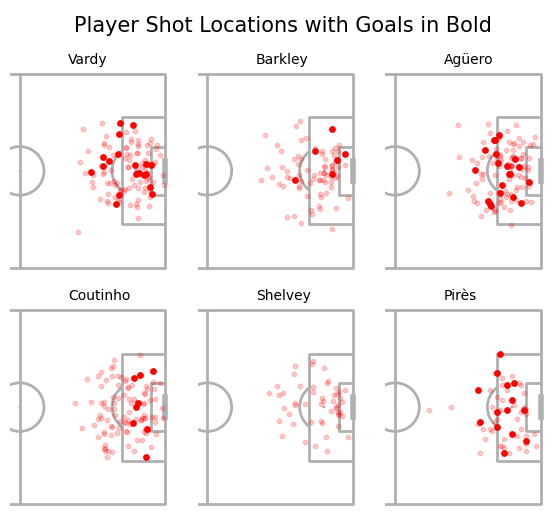

In [239]:
pitch = Pitch(half=True)

fig,axs = pitch.grid(ncols=3, nrows=2, axis=False, title_height=0.05, endnote_height=0, grid_height=0.5)

for player, a in zip(player_shots.player.unique(), axs["pitch"].flat[:len(player_shots.player.unique())]):
    player_i_shots = player_shots[player_shots.player == player]

    for i, row in player_i_shots.iterrows():
        if row["goal"]:
            pitch.scatter(row.x, row.y, alpha=1, color="red", s=15, ax=a)
        else:
            pitch.scatter(row.x, row.y, alpha=0.2, color="red", s=10, ax=a)

    a.text(80, -4, player, fontsize=10)

axs["title"].text(0.12, 0.5, "Player Shot Locations with Goals in Bold", fontsize=15)

plt.show()

---

### Analysing Choice of Priors

In this section, we choose three different categories of priors:

- Uniform.
- Bad choices.
- Current choices (already fitted).

We will use the single-level extended model for this, and see how the performance and results differ for different sets of priors.

#### Uniform priors

We will use a wide uniform distribution, ranging from -100 to 100 for each predictor to ensure we are not being too restrictive.

In [53]:
unif_priors = {"Intercept": bmb.Prior("Uniform", lower=-100, upper=100)} | {pred: bmb.Prior("Uniform", lower=-100, upper=100) for pred in full_model_predictors}

full_baseline.set_priors(unif_priors)

unif_fitted = full_baseline.fit(draws=100, tune=100, chains=4, target_accept=0.95)

Modeling the probability that goal==1
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, distance_to_goal, shot_angle, dist_angle_interaction, gk_distance_to_goal, players_in_shot_triangle, opponents_in_radius, shot_body_part, shot_first_time, gk_in_shot_triangle, shot_one_on_one, shot_open_goal, shot_technique, under_pressure]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 1715 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [54]:
unif_preds = az.summary(full_baseline.predict(unif_fitted, inplace=False), kind="stats")

#### Bad priors

We will choose priors with small standard deviations and add opposite predictions to what we have in the current choices (for example predicting a positive effect for `distance_to_goal`).

In [192]:
bad_priors = {
    "Intercept": bmb.Prior("SkewNormal", mu=0, sigma=0.25, alpha=2),
    "distance_to_goal": bmb.Prior("SkewNormal", mu=0, sigma=0.25, alpha=2),
    "dist_angle_interaction": bmb.Prior("Normal", mu=0, sigma=0.25),
    "shot_angle": bmb.Prior("SkewNormal", mu=0, sigma=0.25, alpha=-2),
    "gk_distance_to_goal": bmb.Prior("Normal", mu=0, sigma=0.25),
    "players_in_shot_triangle": bmb.Prior("SkewNormal", mu=0, sigma=0.25, alpha=[-5,-4,-3,-2,-1,0,1,2,3,4,5]),
    "opponents_in_radius": bmb.Prior("SkewNormal", mu=0, sigma=0.25, alpha=[1,0,-1,-2]),
    "shot_body_part": bmb.Prior("Normal", mu=0, sigma=0.25),
    "shot_first_time": bmb.Prior("Normal", mu=0, sigma=0.25),
    "gk_in_shot_triangle": bmb.Prior("SkewNormal", mu=0, sigma=0.25, alpha=2),
    "shot_one_on_one": bmb.Prior("SkewNormal", mu=0, sigma=0.25, alpha=-2),
    "shot_open_goal": bmb.Prior("SkewNormal", mu=0, sigma=0.25, alpha=-4),
    "shot_technique": bmb.Prior("Normal", mu=0, sigma=0.25),
    "under_pressure": bmb.Prior("SkewNormal", mu=0, sigma=0.25, alpha=2)
}

full_baseline.set_priors(bad_priors)

bad_fitted = full_baseline.fit(draws=100, tune=100, chains=4, target_accept=0.95)

Modeling the probability that goal==1
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, distance_to_goal, shot_angle, dist_angle_interaction, gk_distance_to_goal, players_in_shot_triangle, opponents_in_radius, shot_body_part, shot_first_time, gk_in_shot_triangle, shot_one_on_one, shot_open_goal, shot_technique, under_pressure]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 158 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [193]:
bad_preds = az.summary(full_baseline.predict(bad_fitted, inplace=False), kind="stats")

#### Current priors

We already have this model fitted as `full_baseline_fitted`.

#### Comparison

We will compare the different prior choices not just to each other, but to a normal logistic regression model too. This model will be fitted on the rest of the data not used for the models thus far, and used to predict the same values as the models above.

For more detail on how this model is fitted of this model, see `Non-Bayesian Modelling.ipynb`.

In [57]:
X_train = df.iloc[~df_prem.index][full_model_predictors].reset_index(drop=True)
y_train = df.iloc[~df_prem.index]["goal"].reset_index(drop=True)

X_train = X_train.replace({True: 1, False: 0, np.nan: 0})

for col in categoricals[:-2]:
    X_train[col] = X_train[col].astype("category")

X_train[["distance_to_goal","shot_angle","gk_distance_to_goal"]] = scaler.fit_transform(X_train[["distance_to_goal","shot_angle","gk_distance_to_goal"]])

cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_train_encoded = pd.DataFrame(cat_encoder.fit_transform(X_train[categoricals[:-2]]))

X_train = pd.concat([X_train[["distance_to_goal","shot_angle","gk_distance_to_goal"]], X_train_encoded], axis="columns")

X_train = sm.tools.add_constant(X_train)

In [58]:
X_test = pd.concat([df[["distance_to_goal","shot_angle","gk_distance_to_goal"]].reset_index(drop=True),
                          pd.DataFrame(cat_encoder.transform(df[categoricals[:-2]]))], axis="columns")
X_test = sm.tools.add_constant(X_test)

y_test = df.goal.values

logit = sm.Logit(y_train, X_train).fit()

logit_preds = logit.predict(X_test)

         Current function value: 0.254243
         Iterations: 35


C:\Users\schol\miniforge3\envs\diss\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [194]:
prior_preds = pd.DataFrame({"Uniform": unif_preds.iloc[az.summary(full_baseline_fitted).shape[0]:,0].values,
                            "Bad": bad_preds.iloc[az.summary(full_baseline_fitted).shape[0]:,0].values,
                            "Current": full_baseline_preds.iloc[az.summary(full_baseline_fitted).shape[0]:,0].values,
                            "Non-Bayesian": logit_preds})

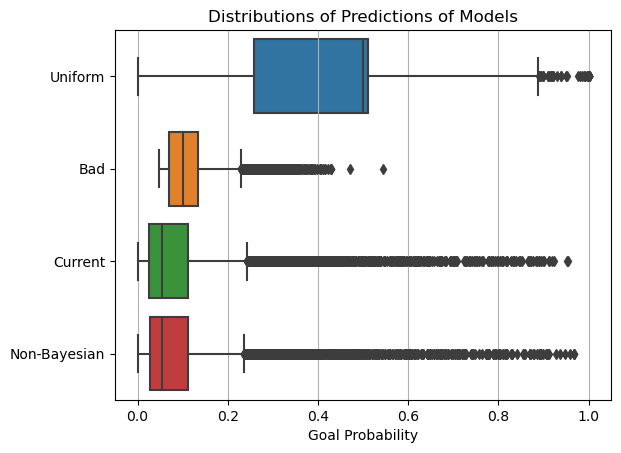

In [198]:
sns.boxplot(prior_preds, orient="h")

plt.title("Distributions of Predictions of Models")
plt.xlabel("Goal Probability")
plt.grid(axis="x")

plt.show()

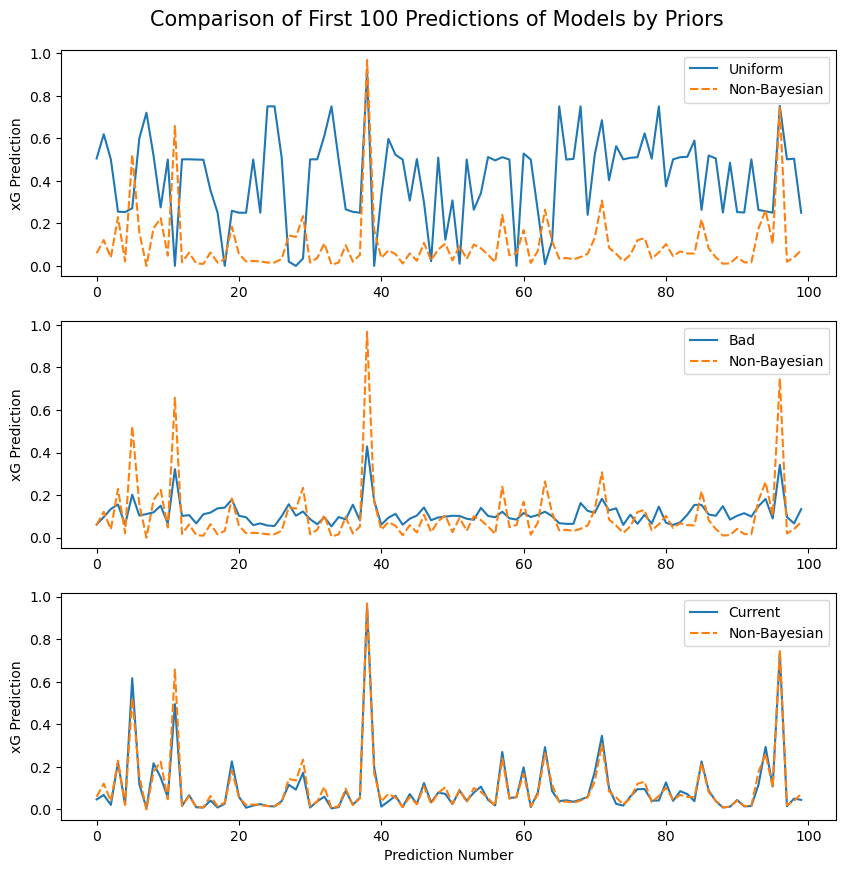

In [210]:
f, a = plt.subplots(nrows=3, figsize=(10,10))

for i in range(3):
    sns.lineplot(prior_preds.iloc[:100,[i,-1]], ax=a[i])
    a[i].set_ylabel("xG Prediction")

a[2].set_xlabel("Prediction Number")

plt.suptitle("Comparison of First 100 Predictions of Models by Priors", fontsize=15, y=0.92)

plt.show()

Using uniform priors leads to very poor predictions compared to the other choice and non-Bayesian predictions. Moreover, using the "bad" narrow priors leads to better predictions but with much smaller variance. Finally, with the current choices, the predictions are almost identical to the non-Bayesian model.